In [4]:
from lmdec.decomp.iter_methods import PowerMethod, SuccessiveStochasticPowerMethod
from lmdec.array.core import rmse_k
from lmdec.array.core.transform import acc_format_svd
import dask.array as da
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py

In [5]:
array_file_path = '/Users/tnonet/Documents/SVD_Matricies/data/10K_40K.h5py'

assert os.path.isfile(array_file_path)
array_file_path = os.path.abspath(array_file_path)
f = h5py.File(array_file_path, 'r')
snp_array = dask.array.from_array(f['/array'])
m, n = snp_array.shape

# Power Method vs Successive Stochastic Power Method

In [10]:
PM1 = PowerMethod(max_iter = 50, k=10, buffer = 20, tol=1e-4, scoring_method='rmse')
U, S, V = PM1.svd(snp_array)
print('U.shape: ', U.shape)
print('S.shape: ', S.shape)
print('V.shape: ', V.shape)

U.shape:  (10000, 10)
S.shape:  (10,)
V.shape:  (10, 40000)


In [20]:
print(PM1.time)
PM1.tol_iterations

212.46601605415344


[0.001050026329940678,
 0.000819724344970943,
 0.0006784319726017507,
 0.0005806203835288418,
 0.0005083459801725906,
 0.00045109634652719735,
 0.0004041977328223736,
 0.00036553371177377807,
 0.00033366944475163833,
 0.0003070286896507536,
 0.0002837506432160364,
 0.00026306230204116383,
 0.0002447192888795756,
 0.00022849142150123202,
 0.00021413643572115067,
 0.0002014174094272473,
 0.000190111158642062,
 0.00018001224238583163,
 0.0001709365574362639,
 0.0001627243482428108,
 0.00015524054663850295,
 0.00014837262073682714,
 0.0001420281092081437,
 0.0001361328565196834,
 0.00013062924271346096,
 0.0001254736632449676,
 0.00012063338689088518,
 0.00011608339651276417,
 0.00011180369499552615,
 0.00010777724566167473,
 0.00010398850854376703,
 0.00010042247515469785,
 9.706412642734649e-05]

In [13]:
SSPM = SuccessiveStochasticPowerMethod(k = 6,
                                       max_sub_iter=15,
                                       buffer = 20,
                                       scoring_method='rmse',
                                       sub_start='warm',
                                       tol=1e-4,
                                       f=.5,
                                       p=1)

In [14]:
Us, Ss, Vs = SSPM.svd(snp_array)

In [19]:
print(SSPM.time)
SSPM.tol_iterations

152.68358898162842


[[0.004372556515235249,
  0.0007755700414574764,
  0.0006367489089352777,
  0.0005385914392172224,
  0.00046777293721068924,
  0.0004157006188853364,
  0.00037718187390401467,
  0.00034860899342804006,
  0.00032445032023058635,
  0.00030070211427734857,
  0.0002782104424288385,
  0.0002579637806083059,
  0.00024007512585308164,
  0.0002243082112585698,
  0.00021034961065694835],
 [0.005680879789294797,
  0.00036346546744927497,
  0.00029388415478141594,
  0.0002461894776076532,
  0.00021281070617994556,
  0.00018777792243466714,
  0.0001680942043263104,
  0.00015209346111292167,
  0.00013877920391378552,
  0.0001275437376253366,
  0.00011808593320407221,
  0.00011057579470296017,
  0.00010559207419815686,
  0.00010140424259559759,
  9.669191960208849e-05]]

In [41]:
tol_plt_inter = []
for sub_list in SSPM.tol_iterations:
    tol_plt_inter += sub_list[-1:]

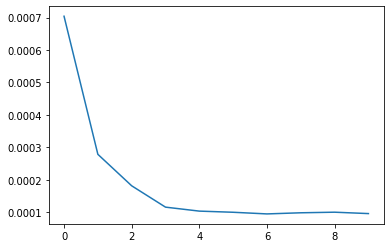

In [42]:
plt.plot(tol_plt_inter)

# Ratio of SubArray Eigenvalues vs Array Eigenvalues

In [21]:
PM3 = PowerMethod(max_iter = 50, k=10, buffer = 10, tol=1e-5, scoring_method='rmse')
U, S, V = PM3.svd(snp_array)

In [22]:
SSPM = SuccessiveStochasticPowerMethod(k = 6,
                                       max_sub_iter=15,
                                       buffer = 20,
                                       scoring_method='rmse',
                                       sub_start='warm',
                                       tol=1e-4,
                                       f=.1,
                                       p=1)
Us, Ss, Vs = SSPM.svd(snp_array)

8.939044624950755
7.027253444641417
5.763308873866308
4.939867252145988
4.348466437248159
4.012670940032613
3.6112762860327896
3.2957604878043583


In [23]:
ratios = []
try:
    S = S.compute()
except:
    S = S
    
p = len(SSPM.value_iterations)
k = len(SSPM.value_iterations[0][0])
for i in range(p):
    sub_ratios = [SSPM.value_iterations[p-1][-1][j]/
                  SSPM.value_iterations[i][-1][j] for j in range(k)]
    ratios.append(sub_ratios)

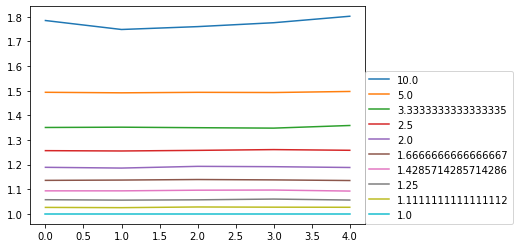

In [24]:
for i, r in enumerate(ratios):
    plt.plot(r[0:5], label=SSPM.value_scalers[i])
plt.legend(loc=(1,0))

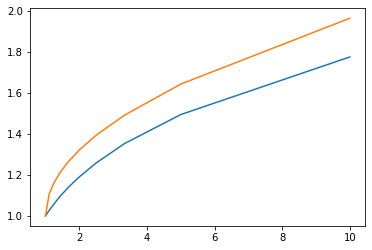

In [36]:
avg_ratio = [np.mean(r[0:5]) for r in ratios]

plt.plot(SSPM.value_scalers, avg_ratio)

def eigen_scaler_sqrt(x):
    return .321*np.sqrt(np.array(x)-1) + 1

def eigen_scaler_ln(x):
    return .365*np.log(x) + 1

plt.plot(SSPM.value_scalers, eigen_scaler_sqrt(SSPM.value_scalers))